In [42]:
%load_ext autoreload
%autoreload 2

In [122]:
import pandas as pd
import numpy as np
from save_recipes import agg_data
import featurize_ingredients as fti
import matplotlib.pyplot as plt
import pigeonXT as pixt
import pickle
import fasttext.util
import fasttext
from tqdm import tqdm

## Read in data and label non ingredient grams

In [ ]:
# !python save_recipes.py
# !python get_embeddings.py

In [2]:
dataset = pd.read_csv("../clean_data/all/all_recipes_nutrient.csv")
top_unigram_cts, top_bigram_cts, gram2idx = fti.choose_top_grams(dataset) 

# Encode unigram/bigram ingredient vectors for each recipe
ing_features = np.array([
        fti.one_hot_encode_raw_ingrs(ingrs, gram2idx)
        for ingrs in dataset["ingredients"]
    ])

ing_df = pd.DataFrame(ing_features, index = dataset['url'])

Using 498 unigrams that occur over 20 times
Using 491 bigrams that occur over 20 times


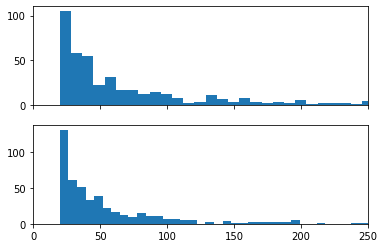

In [14]:
# Plot top occurring ingredients (long tail unploted)
fig, axs = plt.subplots(2,1, sharex=True)
axs[0].set_xlim([0,250])
_ = axs[0].hist(top_unigram_cts.values(), bins=400)
_ = axs[1].hist(top_bigram_cts.values(), bins=200)

In [3]:
# Find all noisy unigrams and bigrams
def get_sorted_grams(gram_cts: dict):
    sorted_grams = {}
    for ingr, ct in gram_cts.items():
        if ct in sorted_grams:
            sorted_grams[ct].append(ingr)
        else:
            sorted_grams[ct] = [ingr]
    
    sorted_cts = list(sorted_grams.keys())
    sorted_cts.sort(reverse=True)
    sorted_grams_list = []
    for ct in sorted_cts:
        sorted_grams_list.extend(sorted_grams[ct])
    
    return sorted_grams_list

In [35]:
# Label grams to exclude
unigram_annos = pixt.annotate(
                    get_sorted_grams(top_unigram_cts),
                    options=['0', '1'], # 0/1 means non-ing/ing
                    buttons_in_a_row=1,
                    include_skip=False,
                    include_back=True,
                    )

HTML(value='0 of 498 Examples annotated, Current Position: 0 ')

Output()

In [36]:
# Bigram edge cases
# 1: dark soy, oil canola, ground pork, flavored oil, granulated sugar, pepper powder
# 1: large eggs, large egg; Shaoxing wine, shaoxing wine; oil canola, canola oil;
# warm water, hot water, cold water, boiling water; powdered sugar, rock sugar, confectioners’ sugar
# 0: clove garlic

def save_annotations_dict(annotations, file_path):
    with open(file_path, "wb") as f:
        pickle.dump(annotations, f)

save_annotations_dict(annotations, "../clean_data/all/non_ing_bigrams_dict.pkl")
save_annotations_dict(unigram_annos, "../clean_data/all/non_ing_unigrams_dict.pkl")

In [39]:
with open("../clean_data/all/non_ing_bigrams_dict.pkl", "rb") as f:
    foo = pickle.load(f)
    
print(len(foo))

491


## Convert each ingredient gram to an embedding

In [54]:
top_ing_unigrams, top_ing_bigrams, grams2idx = fti.choose_top_grams(dataset, exclude_non_ing=True)

Using 498 unigrams that occur over 20 times
Using 491 bigrams that occur over 20 times
loaded grams to exclude from ../clean_data/all/non_ing_unigrams_dict.pkl
pruned 498 grams, left with 159 ingredient grams
loaded grams to exclude from ../clean_data/all/non_ing_bigrams_dict.pkl
pruned 491 grams, left with 160 ingredient grams


In [186]:
ing_df = fti.featurize_ingredients(dataset, save=True, embedding_dim=10)
ing_df.head()

Using 498 unigrams that occur over 20 times
Using 491 bigrams that occur over 20 times
Loaded non ingredient grams to filter out from ../clean_data/all/non_ing_unigrams_dict.pkl
Left with 159 ingredient grams / 498 total grams
Loaded non ingredient grams to filter out from ../clean_data/all/non_ing_bigrams_dict.pkl
Left with 160 ingredient grams / 491 total grams
Loading model into memory ... 


Loaded model in  0.55 min
saving to clean_data/all/ing_features.csv



,0,1,2,3,4,5,6,7,8,9
https://glebekitchen.com/miso-chicken-with-maple-and-ginger/,-0.030270,-0.055893,-0.017842,-0.026782,0.027044,-0.033880,0.029945,0.008558,0.015077,0.022074
https://glebekitchen.com/tonkotsu-ramen-home/,-0.042640,-0.070331,-0.021128,-0.035811,0.034822,-0.033868,0.033495,-0.000416,0.000641,0.019840
https://glebekitchen.com/garlic-ginger-grilled-chicken/,-0.023229,-0.026423,-0.015147,-0.022531,0.022939,-0.015396,0.019490,0.002378,0.001663,0.007099
https://glebekitchen.com/tonkotsu-ramen-broth-home/,0.000970,-0.063905,-0.042373,-0.026290,0.019207,-0.034303,0.053536,0.009052,0.023898,0.049634
https://glebekitchen.com/japanese-chicken-curry-curry-rice/,-0.041986,-0.056194,-0.018283,-0.028208,0.035671,-0.014228,0.031947,-0.001215,-0.005356,0.007310


In [164]:
ing_gram_cts = {
        gram : ct 
        for gram, ct in 
        list(ing_unigram_cts.items()) + list(ing_bigram_cts.items())
    }

In [149]:
# Check: entirely non-ingredient ingredient lists are zero'd out
ing_df[ing_df.index == "https://www.eatingthaifood.com/toasted-rice-powder-recipe/"]

,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
https://www.eatingthaifood.com/toasted-rice-powder-recipe/,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


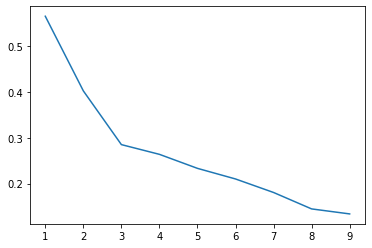

In [188]:
u, s, vh = np.linalg.svd(ing_df.to_numpy()) # s is an array of singular values
plt.plot(range(1,len(s)), s[1:])
# num_svals = int(len(s)/5)
# plt.plot(range(1, num_svals), s[1:num_svals])

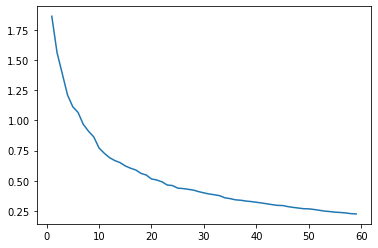

In [184]:
# Experiment: number of dimensions to reduce to
# 10 and 20 looks like a good cutoff
u, s, vh = np.linalg.svd(ing_df.to_numpy()) # s is an array of singular values
num_svals = int(len(s)/5)
plt.plot(range(1, num_svals), s[1:num_svals])

In [ ]:
# Experiment: surface rarest ingredients
# It's pretty good! regularly unigrams repeat in bigrams. exclude at display time
rarest_ings = {}
ct = 0
for url, raw_ingrs in zip(dataset.url, dataset.ingredients):
    grams = fti.extract_ing_grams(raw_ingrs, all_ing_grams)
    freqs = [ing_gram_cts[gram] for gram in grams]
    
    num_rare_grams = 5
    rare_gram_idxs = np.argsort(freqs)[:num_rare_grams]

    rarest_ings[url] = {
        "rare": np.array(grams)[rare_gram_idxs],
        "all": grams,
    }
    
    print(url)
    print(rarest_ings[url]["rare"])
    print(rarest_ings[url]["all"])
    

## Former data aggregation workflow

In [ ]:
all_dfs_nutrient = agg_data()
# all_dfs_nutrient = pd.read_csv("clean_data/all_recipes_nutrient.csv")
all_dfs_nutrient.columns

Number of ingredient grams per recipe


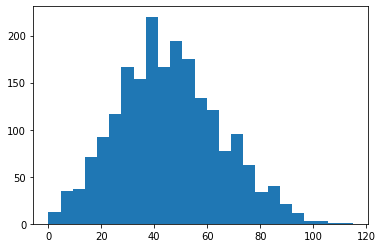

In [11]:
print("Number of ingredient grams per recipe")
encodings = np.stack(all_dfs_nutrient["ingredients_encoding"])
_ = plt.hist(np.sum(encodings, axis=1), bins=25)

In [4]:
# This logic is in agg_data already
check_intermediates = False
if check_intermediates:
    # Get top grams
    top_unigram_cts, top_bigram_cts, gram2idx = choose_top_grams(all_dfs_nutrient)

    # Plot top occurring ingredients (long tail unploted)
    fig, axs = plt.subplots(2,1, sharex=True)
    axs[0].set_xlim([0,250])
    _ = axs[0].hist(top_unigram_cts.values(), bins=200)
    _ = axs[1].hist(top_bigram_cts.values(), bins=200)

    # Featurize ingredients
    all_dfs_nutrient = featurize_ingredients(all_dfs_nutrient, gram2idx)

In [28]:
# Embed all uni/bigrams found in pretrained word2vec
# top_unigram_cts, top_bigram_cts, gram2idx = choose_top_grams(all_dfs_nutrient)
# print(top_bigram_cts.keys())
gram_probs, gram2vec = choose_top_grams(all_dfs_nutrient)

Using 498 unigrams that occur over 20 times
Using 491 bigrams that occur over 20 times
['</s>', 'in', 'for', 'that', 'is', 'on', '##', 'The', 'with', 'said', 'was', 'the', 'at', 'not', 'as', 'it', 'be', 'from', 'by', 'are', 'I', 'have', 'he', 'will', 'has', '####', 'his', 'an', 'this', 'or']
616 of 989 grams mapped to an embedding


In [ ]:
# print(list(gram2vec.items())[:10])
# len(gram2vec["beans"])
len(gram2vec), len(gram_probs)
print(list(gram2vec.items())[0])

In [61]:
all_dfs_nutrient = featurize_ingredients(all_dfs_nutrient, gram2vec, gram_probs)

In [ ]:
all_dfs_nutrient["ingredients_encoding"].iloc[0]